# Learning density estimation with histogram information

## References

[1] Yusuf, I., Igwegbe, G., & Azeez, O. (2020). Differentiable Histogram with Hard-Binning. arXiv preprint arXiv:2012.06311.

[2] Avi-Aharon, M., Arbelle, A., & Raviv, T. R. (2020). DeepHist: Differentiable Joint and Color Histogram Layers for Image-to-Image Translation. arXiv preprint arXiv:2005.03995.

[3] Rubner, Y., Tomasi, C., & Guibas, L. J. (2000). The earth mover's distance as a metric for image retrieval. International journal of computer vision, 40(2), 99-121.

## Motivation
Our baseline model consists of a U-Net architecture with slight modifications (e.g. ELU activation in the convolution layers).

We use MSE as the loss function.

We scale all positive pixel values by adding 0.5. Otherwise, we observe very slow improvements, because the background pixels are very close to our foreground density pixels. This can be seen in the example shown in figure 1.

After training with the scaled density maps, by visual comparison of the ground truth and prediction, we start to observe decent results. In terms of the loss, in particular of the count loss, we still observe poor results. To investigate this, we decide to the histograms in our validation plots.

Looking at the histograms, we observe that the learning, narrows down the range of pixel values, albeit somewhat slowly. We think that explicitly including the histogram information in the learning should help the model determine the range of pixel values to use more rapidly.

In this notebook, we explore approaches on how to do this.

**Figure 1**. Histogram of the density map ground truths. We observe that the background and foreground pixels are very close to each other, this is because of the normalization applied so that each blob sums up to one.

**Figure 2**. Comparison of ground truth and prediction density maps with their respective histograms after epoch 1 using the Sahara dataset.

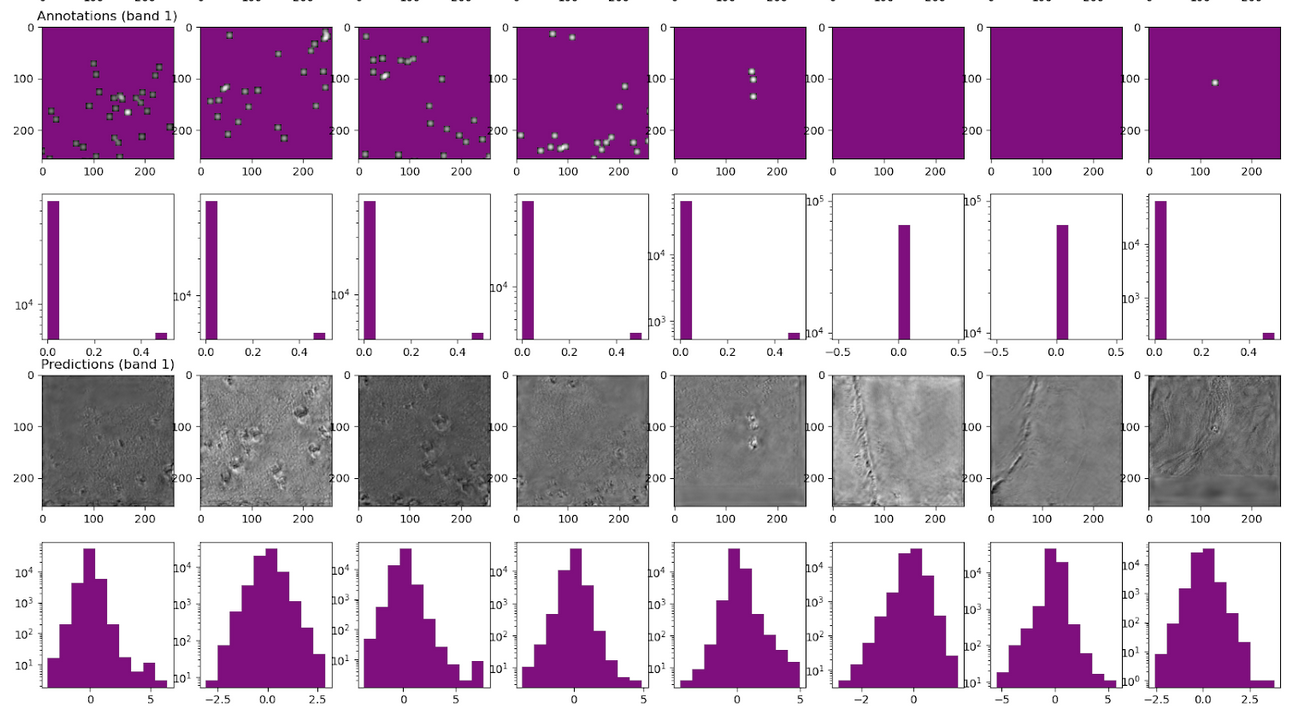

**Figure 3**. Comparison of ground truth and prediction density maps with their respective histograms after epoch 1.

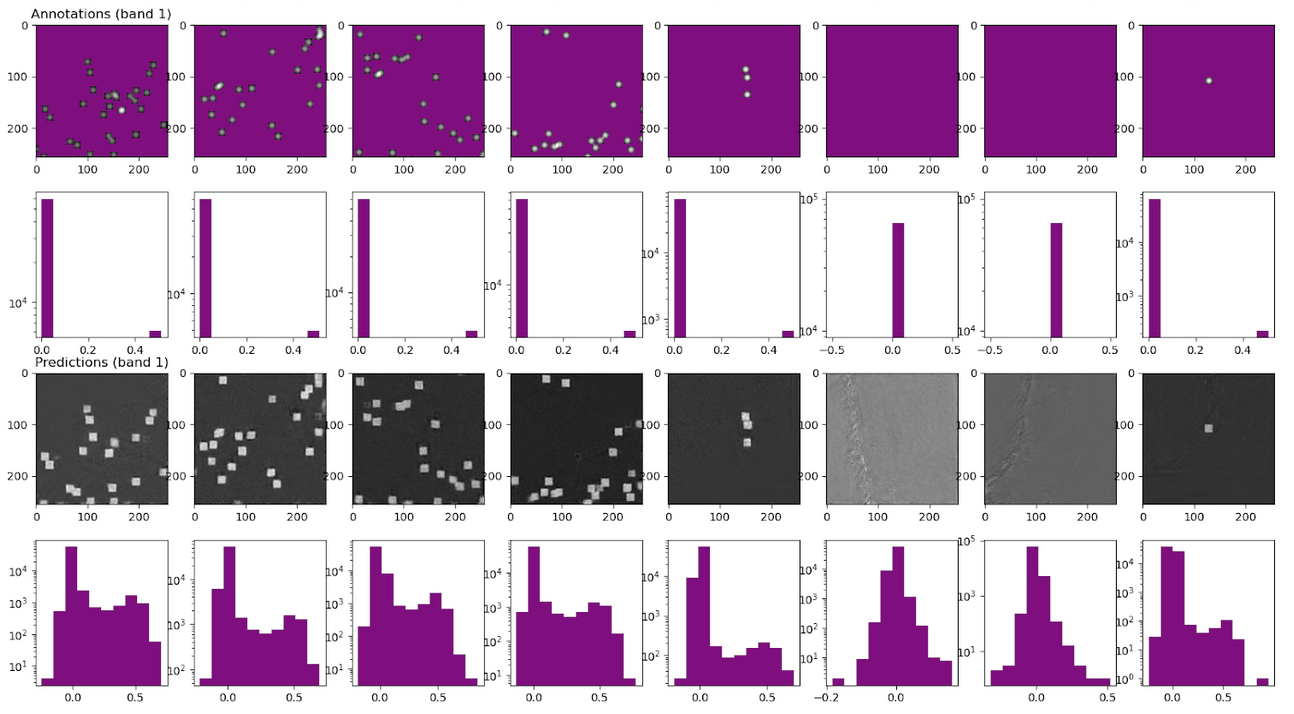

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Test data

In [2]:
def data_generator(image_shape, k, start, stop, seed):
  edges = np.linspace(start, stop, endpoint=True, num=k+1)
  rng = np.random.default_rng(seed=seed)

  distributions = ["normal", "uniform", "pareto", "poisson"]

  def _data_generator():
    while True:
      distribution = rng.choice(distributions, size=1)[0]
      if distribution == "normal":
        image = rng.normal(size=image_shape)
      elif distribution == "uniform":
        image = rng.uniform(size=image_shape)
      elif distribution == "pareto":
        image = rng.pareto(3.0, size=image_shape)
      else:
        image = rng.poisson(size=image_shape)

      hist, _ = np.histogram(image.flatten(), bins=edges)
      hist_normalized = hist / np.sum(hist)
      yield image, hist_normalized
  return _data_generator

## Histogram

We implement and verify the histogram layer from [1].

In [3]:
class Histogram(tf.keras.layers.Layer):
  def __init__(self, k: int, start: float, stop: float, **kwargs):
    """Compute a differentiable histogram of equally-sized linearly-spaced bins.
    
    Parameters
    ----------
    k
      The number of bins
    start
      The start value of the first bin
    stop
      The stop value of the last bin (inclusive).
    name
      The name of the layer.
    """
    # Implements the layer described in [1].
    super(Histogram, self).__init__(**kwargs)
    self.k = k
    self.start = start
    self.stop = stop
    # Compute the k + 1 edges that define the k bins.
    edges = tf.linspace(self.start, self.stop, num=self.k + 1)
    # The kth bin corresponds to (muk - wk, muk + wk)
    # See [1, Eq. 1]
    # The line below is equivalent to wk = np.diff(edges) / 2
    self.wk = tf.constant(0.5) * (edges[1:] - edges[:-1])
    self.muk = edges[:-1] + self.wk

  def build(self, input_shape):
    # Adapted from TF. See: https://git.io/J89L8 and https://git.io/J89q0
    # Assumes "channels_last" data format.
    input_shape = tf.TensorShape(input_shape)
    if input_shape.dims[-1].value is None:
      raise ValueError("The channel dimension of the inputs "
                       "should be defined. Found `None`.")
    input_channel = int(input_shape[-1])
    kernel_size = (1, 1)
    kernel_shape = kernel_size + (input_channel, self.k)
    self.kernel_ones = tf.ones(kernel_shape)
    self.kernel_minus_ones = tf.constant(-1.0) * self.kernel_ones

  def call(self, inputs):
    # Compute the activation maps
    h = self.activation_map(inputs)
    # Perform the global average pooling
    h = tf.keras.backend.mean(h, axis=[1, 2])

    return h

  def activation_map(self, inputs):
    # Returns the activation map
    # See: [2, p.8, figure 4]
    x = inputs
    # Compute x - muk
    x = tf.keras.backend.conv2d(x,
                                   self.kernel_ones,
                                   padding="same",
                                   data_format="channels_last",)
    x = x - self.muk 
    # Compute |x - muk|
    x = tf.math.abs(x)
    # Compute wk - |x - muk|
    x = tf.keras.backend.conv2d(x,
                                   self.kernel_minus_ones,
                                   padding="same",
                                   data_format="channels_last",)
    x = x + self.wk
    # Compute 1.01 ^ (wk - |x - muk|)
    x = tf.math.pow(tf.constant(1.01), x)
    # Compute the "ReLU at one". See [1, Eq. 2].
    x = tf.keras.backend.relu(x, threshold=1.0, max_value=1.0)
    return x

  def get_config(self):
    return dict(k=self.k, start=self.start, stop=self.stop)

In [4]:
def create_model(input_shape, batch_size):
  input = tf.keras.Input(input_shape, batch_size, name="input")
  output = Histogram(k, start, stop, name="histogram")(input)
  model = tf.keras.Model(inputs=input, outputs=output)
  return model

In [5]:
k = 256
start = -2.0
stop = 2.0 + 1e-3
batch_size = 4
image_shape = (25, 25, 1)
output_signature = (tf.TensorSpec(shape=image_shape), tf.TensorSpec(shape=(k,)))
seed = 1254545
edges = np.linspace(start, stop, endpoint=True, num=k+1)

test_generator = data_generator(image_shape, k, start, stop, seed)
test_ds = tf.data.Dataset.from_generator(test_generator, output_signature=output_signature)
test_ds = test_ds.batch(batch_size)

model = create_model(image_shape, batch_size)

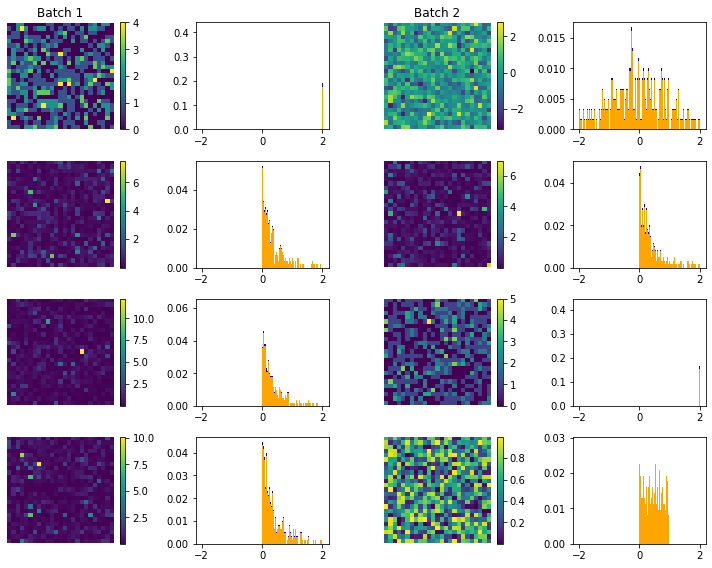

In [6]:
take = 2
fig, axs = plt.subplots(batch_size, 2 * take, figsize=(batch_size * 2.5, batch_size * 2))

hl = Histogram(k, start, stop)

for i, (xs, ys) in enumerate(test_ds.take(take)):
  hs = model.predict(xs)
  for j in range(batch_size):
    img = axs[j, i * take + 0].imshow(xs[j, :, :, 0], cmap="viridis")
    fig.colorbar(img, ax=axs[j, i * take + 0])
    axs[j, i * take + 0].axis("off")
    axs[j, i * take + 1].hist(edges[:-1], edges, weights=ys[j, ...], color="blue")
    axs[j, i * take + 1].hist(edges[:-1], edges, weights=hs[j, ...], color="orange")
    if j == 0:
      axs[j, i * take + 0].set_title(f"Batch {i + 1}")
    np.testing.assert_almost_equal(ys[i, ...].numpy().sum(), 1.0)

fig.tight_layout()

In [7]:
k = 256
start = -1.0
stop = 1.0 + 1e-3
batch_size = 4
image_shape = (256, 256, 1)
output_signature = (tf.TensorSpec(shape=image_shape), tf.TensorSpec(shape=(k,)))
seed = 754857845
edges = np.linspace(start, stop, endpoint=True, num=k+1)

test_generator = data_generator(image_shape, k, start, stop, seed)
test_ds = tf.data.Dataset.from_generator(test_generator, output_signature=output_signature)
test_ds = test_ds.batch(batch_size)

model = create_model(image_shape, batch_size)
model.compile(metrics=["mae"])

In [8]:
# In [1] an absolute error of 0.000158 is reported for the histogram layer.
# With 1 experiment using k=20, we observe a MAE of 0.0021
# With 1 experiment using k=256, we observe a MAE of 1.6345e-04

result = model.evaluate(test_ds, batch_size=100, steps=10)

10/10 [==============================] - 60s 6s/step - loss: 0.0000e+00 - mae: 7.5448e-04


## JointHistogram

We implement the joint histogram from [2], but using the activation maps from [1].

In [9]:
class JointHistogram(Histogram):
  """Computes a differentiable joint histogram."""
  # Implements the joint histogram from [2] but using the activation maps from [1].

  def build(self, input_shape):
    if not (isinstance(input_shape, (tuple, list)) and len(input_shape) == 2):
      raise ValueError("Input must be a tuple/list with 2 image batches")
    input_shape1 = tf.TensorShape(input_shape[0])
    input_shape2 = tf.TensorShape(input_shape[1])
    if not input_shape1.is_compatible_with(input_shape2):
      raise ValueError("Shape mismatch")
    super(JointHistogram, self).build(input_shape1)
    # See: https://git.io/J4CJ2
    self.map_flattened_shape = tf.TensorShape((input_shape1[0], input_shape1[1] * input_shape1[2], self.k))


  def call(self, inputs):
    # Shape: (batch_size, height, width, k)
    histogram_map1 = self.activation_map(inputs[0])
    histogram_map2 = self.activation_map(inputs[1])
    # We flatten the histograms
    # Shape: (batch_size, height * width, k)
    histogram_map1 = tf.reshape(histogram_map1, self.map_flattened_shape)
    histogram_map2 = tf.reshape(histogram_map2, self.map_flattened_shape)
    # See [2, p.8, eq. 13]
    # Input shape: (batch_size, k, height * width) x (batch_size, height * width, k)
    # Output shape: (batch_size, k, k)
    joint_histogram = tf.linalg.matmul(histogram_map1, histogram_map2,
                                       transpose_a=True)
    joint_histogram = tf.constant(1. / histogram_map1.shape[1]) * joint_histogram
    return joint_histogram

In [10]:
def compare_joint_histogram(img1, img2, k=20, start=-1.0, stop=1.0):
  edges = np.linspace(start, stop, endpoint=True, num=k+1)
  jh = JointHistogram(k, start, stop)

  # See: https://numpy.org/doc/stable/reference/generated/numpy.histogram2d.html
  jh_t, _, _ = np.histogram2d(img1.numpy().flatten(), img2.numpy().flatten(), bins=(edges, edges))
  # We apply the same normalization that is used in [2].
  jh_t /= img1.shape[1] * img1.shape[2]

  jh_c = jh([img1, img2])

  print(np.sum(jh_c), np.sum(jh_t))

  fig, ax = plt.subplots(1, 4, figsize=(12, 3))
  ax[0].imshow(img1[0, :, :, 0], cmap="viridis")
  ax[1].imshow(img2[0, :, :, 0], cmap="viridis")
  X, Y = np.meshgrid(edges, edges)
  ax[2].set_title("Layer Implementation")
  ax[2].pcolormesh(X, Y, jh_c[0, ...].numpy().T)
  ax[3].set_title("Numpy Reference")
  ax[3].pcolormesh(X, Y, jh_t.T)
  fig.tight_layout()
  return fig

In [11]:
img1 = tf.random.normal((1, 10, 10, 1))
img2 = tf.random.normal((1, 10, 10, 1))

0.67 0.67


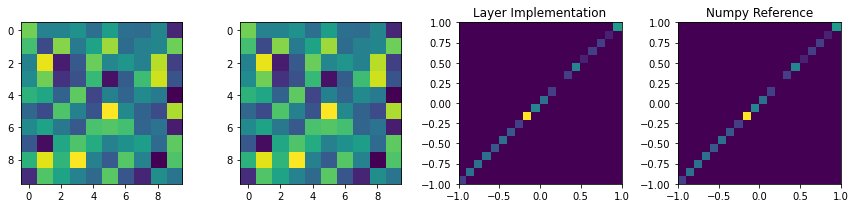

In [12]:
fig = compare_joint_histogram(img1, img1)

0.42999998 0.43000000000000005


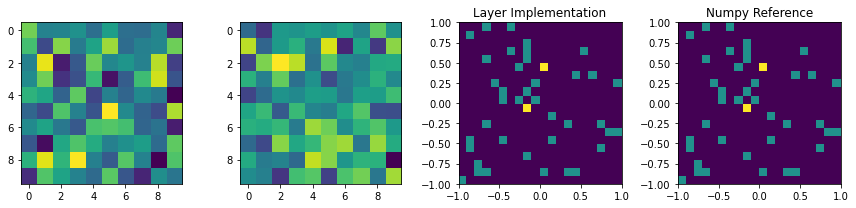

In [13]:
fig = compare_joint_histogram(img1, img2)